In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error
import numpy as np                              
import pandas as pd                        
import matplotlib.pyplot as plt              
import seaborn as sns                           

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   
from tqdm import tqdm_notebook

import warnings                                  
warnings.filterwarnings('ignore')

In [20]:
series = pd.read_csv('../datasets/data.csv', index_col=['date'], parse_dates=['date'])

In [21]:
series.head()

,work,income
date,,
2021-09-30,2,2100
2021-10-03,1,3600
2021-10-04,1,4000
2021-10-05,1,7900
2021-10-06,1,7500


In [26]:
series.tail()

,work,income
date,,
2022-07-04,1,12600
2022-07-05,1,10300
2022-07-06,1,10000
2022-07-07,2,12500
2022-07-08,1,2000


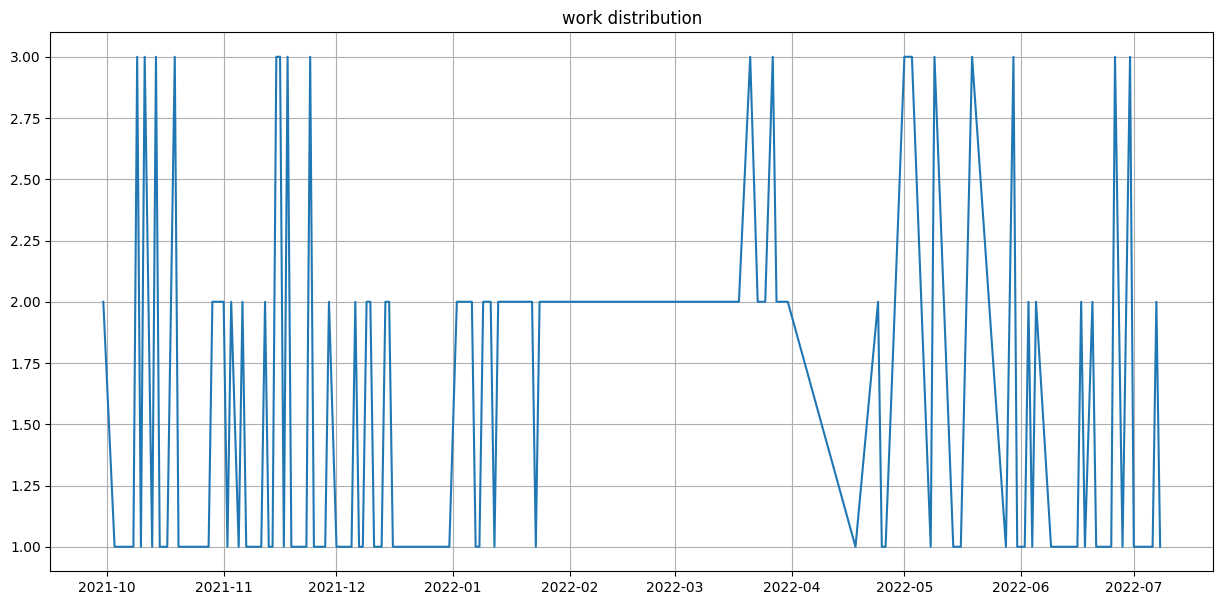

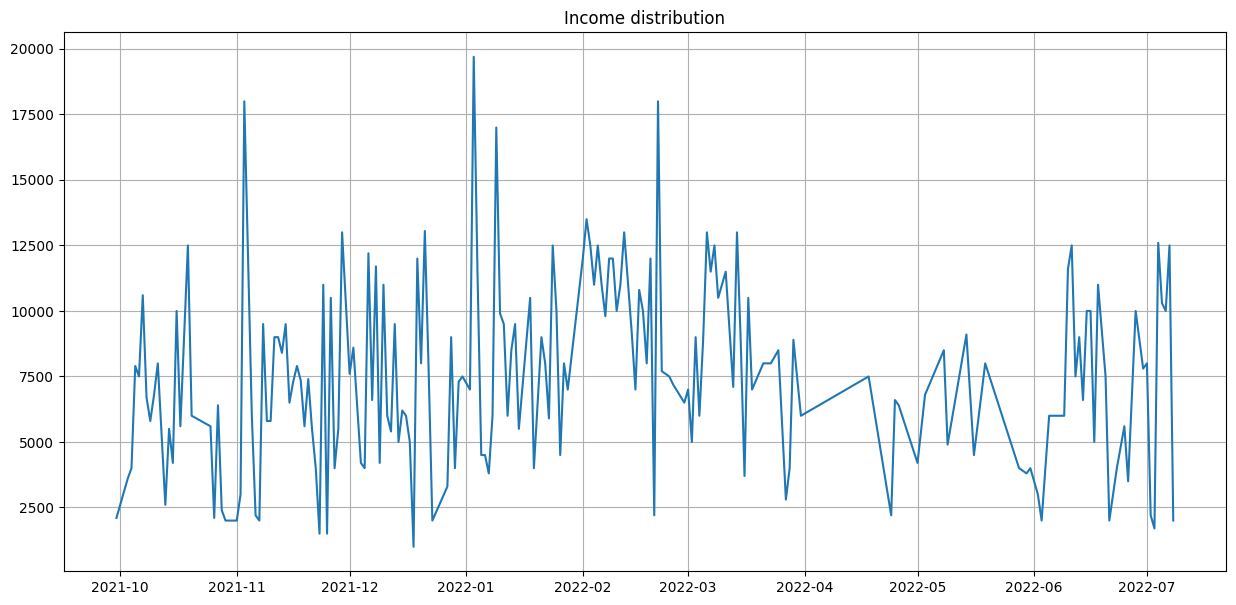

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(series.work)
plt.title('work distribution')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(series.income)
plt.title('Income distribution')
plt.grid(True)
plt.show()

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100